In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import RandomFlip, RandomContrast, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.applications import EfficientNetV2L as base_m
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy as scc
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

SEED = 154
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print(f'Tensorflow version: {tf.__version__}')

D0915 16:37:18.129820283      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0915 16:37:18.129843681      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0915 16:37:18.129847377      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0915 16:37:18.129849969      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0915 16:37:18.129852388      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0915 16:37:18.129855191      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0915 16:37:18.129858397      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0915 16:37:18.

Tensorflow version: 2.12.0


In [2]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
strategy = tf.distribute.TPUStrategy(tpu)
print("Running on TPU")
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [3]:
image_size = (480,480)
epochs = 12
tf_record_sample_size = 4096
batch_size = 128 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
train = tf.io.gfile.glob("/kaggle/input/*/tfrecords/*.tfrec")

In [4]:
filenames = tf.io.gfile.glob("/kaggle/input/*/tfrecords/*.tfrec")
filenames.sort()
random.Random(SEED).shuffle(filenames)

train_split = 0.8
val_split = 0.1

num_files = len(filenames)
train_end = int(train_split * num_files)
val_end = int((train_split + val_split) * num_files)

train_filenames = filenames[:train_end]
val_filenames = filenames[train_end:val_end]
test_filenames = filenames[val_end:]

In [5]:
# def decode_image(image_data):
#     image = tf.image.decode_jpeg(image_data, channels=3)
#     image = tf.cast(image, tf.float32) / 255.0
#     image = tf.reshape(image, [*image_size, 3])
#     return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "feature0": tf.io.FixedLenFeature([], tf.string),
        "feature1": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = tf.io.decode_jpeg(example['feature0'])
    label = tf.cast(example['feature1'], tf.int64)
    return image, label

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
#     options = tf.data.Options()
#     options.experimental_deterministic = True
#     dataset = dataset.with_options(options)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.stateless_random_flip_left_right(image, seed=(SEED, SEED))
    image = tf.image.stateless_random_saturation(image, lower=0.8, upper=2.0, seed=(SEED + 1, SEED + 1))
    return image, label

def get_dataset(filenames, augment=False, repeat=False):
    dataset = load_dataset(filenames)
    dataset_size = (len(filenames) - 1) * tf_record_sample_size
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=SEED)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset, dataset_size

In [6]:
train_ds, train_size = get_dataset(train_filenames, augment=True, repeat=True)
val_ds, val_size = get_dataset(val_filenames)
test_ds, test_size = get_dataset(test_filenames)

In [7]:
def create_model():
    data_augmentation = Sequential([
        RandomFlip('horizontal'),
        RandomContrast(0.2),
    ])

    base_model = base_m(input_shape=(*image_size, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        data_augmentation,
        base_model,
        GlobalAveragePooling2D(),
        Dense(4096, activation='swish'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1024, activation='swish'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1000)
    ])

    model.compile(
        optimizer=Adam(lr_init),
        loss=scc(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [8]:
lr_init = 0.003
es = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    min_delta=0.0005,
    restore_best_weights=True,
    verbose=1
)

In [9]:
def schedule(epoch,lr):
    if epoch < 10:
        return (epoch+1)*lr_init/10
    elif epoch < 20:
        return lr
    return lr * tf.math.exp(-0.1)
lr_scheduler = LearningRateScheduler(schedule,verbose=1)

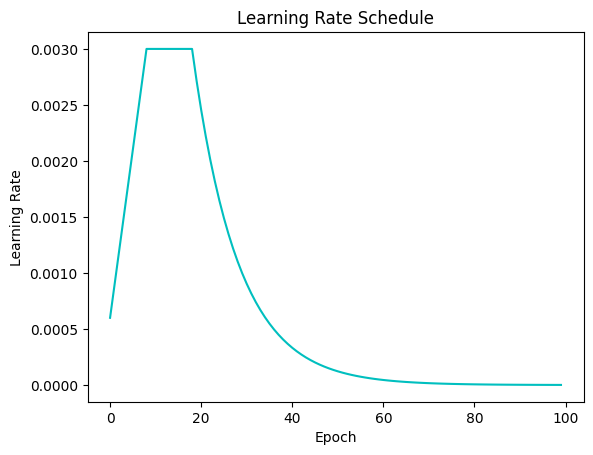

In [10]:
lr = 0.003
x = list(range(100))
y = []
for i in range(100):
    lr = schedule(i + 1, lr)
    y.append(lr)

plt.plot(x, y, c="c")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

In [11]:
if not os.path.exists("chkpts"):
    os.makedirs("chkpts")
    
checkpoint_filepath = 'chkpts/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [13]:
with strategy.scope():
    model = create_model()

473176280/473176280 [==============================] - 12s 0us/step


In [14]:
steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size

In [15]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[es, model_checkpoint_callback, lr_scheduler]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.00030000000000000003.
Epoch 1/12


2024-09-15 16:39:29.686014: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2024-09-15 16:39:31.087934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


644/644 [==============================] - ETA: 0s - loss: 2.3031 - accuracy: 0.4647

2024-09-15 16:58:07.574039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-09-15 16:58:08.416444: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


644/644 [==============================] - 1306s 2s/step - loss: 2.3031 - accuracy: 0.4647 - val_loss: 1.7429 - val_accuracy: 0.5648 - lr: 3.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0006000000000000001.
Epoch 2/12
644/644 [==============================] - 1177s 2s/step - loss: 1.4552 - accuracy: 0.6147 - val_loss: 1.3840 - val_accuracy: 0.6266 - lr: 6.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 3/12
644/644 [==============================] - 1181s 2s/step - loss: 1.2982 - accuracy: 0.6501 - val_loss: 1.2855 - val_accuracy: 0.6463 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0012000000000000001.
Epoch 4/12
644/644 [==============================] - 1174s 2s/step - loss: 1.2315 - accuracy: 0.6653 - val_loss: 1.3126 - val_accuracy: 0.6419 - lr: 0.0012

Epoch 5: LearningRateScheduler setting learning rate to 0.0015.
Epoch 5/12
644/644 [==============================] - 1176s 2s/ste

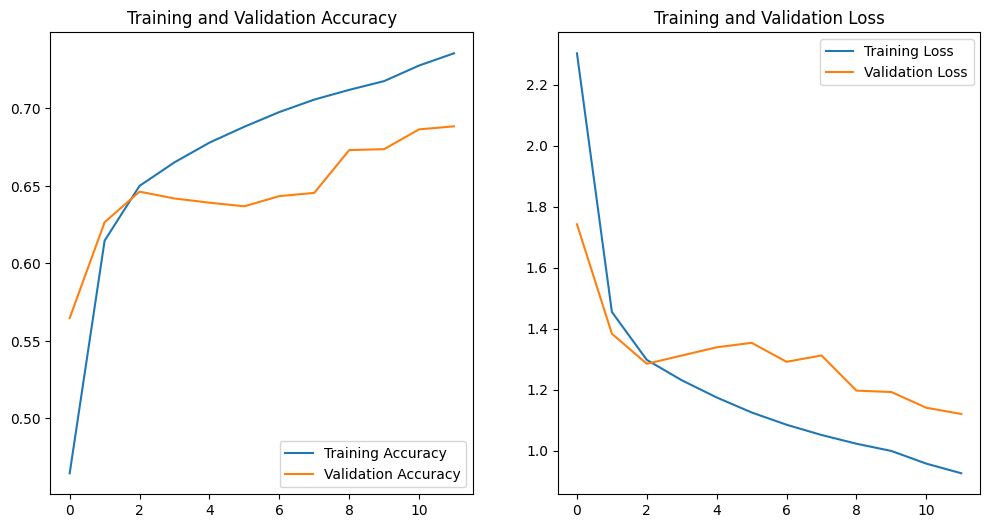

In [16]:
plot_history(history)

In [17]:
model.save('model.h5')

In [18]:
import pickle

with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [19]:
test_steps = test_size // batch_size
if test_size % batch_size != 0:
    test_steps += 1

test_loss, test_accuracy = model.evaluate(test_ds, steps=test_steps)

test_loss = round(test_loss, 2)
test_accuracy = round(test_accuracy * 100, 2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}%")

80/80 [==============================] - 117s 1s/step - loss: 2.0456 - accuracy: 0.5082
Test Loss: 2.05
Test Accuracy: 50.82%
